creating CM1 animations for precip and pwat<br>
usage: python CM1_animations.py exp_file<br>
date: Mar 2021

In [1]:
import os
import sys
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# for animations
from PIL import Image
warnings.filterwarnings('ignore')

define functions

In [2]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N
    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg    

In [3]:
def read_data(data_dir):
    os.chdir(data_dir)
    file_name = glob('*nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    # 3d data for wind vector and cold pool
    th = data_3d.th[:,:20,:,:] # first 20 levels
    qv = data_3d.qv[:,:20,:,:]
    u = data_3d.uinterp[:,:20,:,:]
    v = data_3d.vinterp[:,:20,:,:]

    # 2d data
    prate = data_2d.prate[:,:,:]
    pwat = data_2d.pwat[:,:,:]
    cwp = data_2d.cwp[:,:,:]
    cape = data_2d.cape[:,:,:]
    cin = data_2d.cin[:,:,:]
        
    return (th,qv,prate*3600*24,pwat*1000,u,v)

In [4]:
#get weather or weather2 <br>
#server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
server = '/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne'
os.chdir(server)
#exp_name = glob('CM1*')
#print(exp_name)

In [5]:
#exp_name = sys.argv[1] # input argument for experiment name
exp_name = 'CM1_LD2km_RAD4K_OPENMPshear_216x216_U15H2km_eqtset2'
print('EXP_NAME:' ,exp_name)

EXP_NAME: CM1_LD2km_RAD4K_OPENMPshear_216x216_U15H2km_eqtset2


In [6]:
(th1,qv1,prate1,pwat1,u1,v1) = read_data(server+'/'+exp_name)

dimenstion variable

In [7]:
x_dim = pwat1.lon
y_dim = pwat1.lat
z_dim = th1.lev
t_dim = np.arange(pwat1.shape[0])/3 # hourly

====== create animations ======

In [8]:
fig_dir = server+'/'+exp_name+'/fig'
os.system('mkdir -p '+fig_dir)
#print(fig_dir)

0

Text(0, 0.5, '[km]')

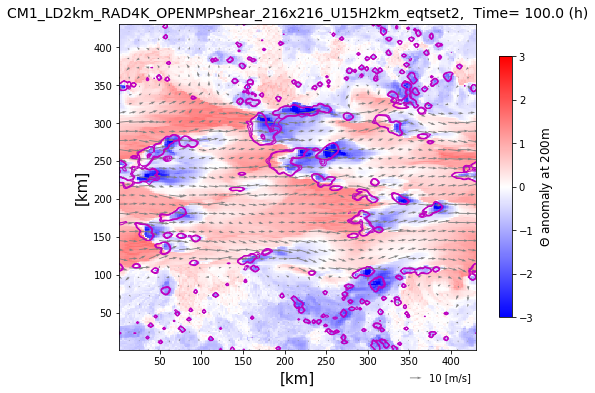

In [46]:
x_mesh,y_mesh = np.meshgrid(x_dim,y_dim)

t = 300
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.contour(x_dim,y_dim,prate1[t,:,:],levels=[10,20,30],colors=['m']
            ,linewidths=1)
cf = ax.pcolor(x_dim,y_dim,th1[t,2,:,:]-th1[t,2,:,:].mean(),cmap='bwr',vmin=-3,vmax=3)
cbar = plt.colorbar(cf,ax=ax,shrink=0.8)
Q = ax.quiver(x_mesh[::6,::6],y_mesh[::6,::6],u1[t,7,::6,::6].values,v1[t,7,::6,::6].values,color='grey')
qk = ax.quiverkey(Q, 0.65, 0.06, 10, r'10 [m/s]', labelpos='E',
                   coordinates='figure')
cbar.set_label(r'$\Theta$ anomaly at 200m',fontsize=12)
ax.set_title(exp_name+',  Time= '+ str(np.round(t/3,2)) + ' (h)',fontsize=14)
ax.set_xlabel('[km]',fontsize=15)
ax.set_ylabel('[km]',fontsize=15)

In [ ]:
for t in range(0,len(t_dim),3):
    fig = plt.figure(figsize=(8,6))
    plt.contour(x_dim,y_dim,prate1[t,:,:],levels=[10,20],colors=['k']
            ,linewidths=1)
    plt.pcolor(x_dim,y_dim,pwat1[t,:,:],cmap='Spectral',
           vmax=65,vmin=45)
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label('[mm]',fontsize=12)
    plt.title(exp_name+',  Time= '+ str(np.round(t/3,2)) + ' (h)',fontsize=14)

    #     # save figs
    if (t < 10):
    plt.savefig(fig_dir+'/'+exp_name+'_000'+str(t)+'.png',dpi=300)
    elif (10 <= t) and (t < 100):
    plt.savefig(fig_dir+'/'+exp_name+'_00'+str(t)+'.png',dpi=300) 
    elif (100 <= t) and (t < 1000):
    plt.savefig(fig_dir+'/'+exp_name+'_0'+str(t)+'.png',dpi=300)
    else:
    plt.savefig(fig_dir+'/'+exp_name+'_'+str(t)+'.png',dpi=300)
    plt.close(fig)

In [ ]:
fp_in = fig_dir+'/*.png'
fp_out = fig_dir+'/'+exp_name+'.gif'

In [ ]:
img, *imgs = [Image.open(f) for f in sorted(glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=200, loop=0)